# DIC Lab1 Part 3

Submitted by asinha6@buffalo.edu and sdhar2@buffalo.edu

# Twitter Application Development

##### shiny app link - https://sdhar2.shinyapps.io/DICLab1/

In [5]:
# library(rtweet)
# library(revgeo)
library(maps)
library(ggplot2)
# library(GEOmap)
library(fiftystater)
library(data.table)
library(dplyr)

Warning message:
"package 'data.table' was built under R version 3.5.2"Warning message:
"package 'dplyr' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



##### Create a valid list of states in USA

In [4]:
lst_valid_states <- table(fifty_states$id)
lst_valid_states <- as.data.table(lst_valid_states)
lst_valid_states <- lst_valid_states[, c(V1)]
lst_valid_states <- paste(lst_valid_states, collapse = '|')

##### Accessing Twitter APIs require these keys and tokens

For this project, We have used 'rtweet' package. This package is used to collect tweets via Twitter's REST Application Program Interfaces (API). The documentation for this API can be found at the following URL: <https://developer.twitter.com/en/docs>.

For accessing the Twitter API, We first created a developer account on Twitter. After successfully getting access to a developer account, We created an APP which is required if you want to access and use twitter data in any of your application. After creating an APP in my twitter developer account, We got the consumer key and secret. The last step of this task requires generating two more things that are needed to access the twitter APIs viz. access token and access secret. We generated these two for the App which we created in the previous step.


In [ ]:
consumer_key <- "z1BD0Ve29tjorbsAhww9cptHh"
consumer_secret <- "MabrL9Fj2an40weqifg9e1hYtLLyHStzMYuK8ijc2WluiSjdMX"
access_token <- "1095681775098048512-UVirSgwpToXdBB25V6lLnEUKpk7t3x"
access_secret <- "Zj8BamGbYQaGQjsUO4Oi7in9vsaVBgARqf1BeEIofONeV"

##### Sends request to generate OAuth 1.0 tokens

In [ ]:
create_token(
  app = "flu_map",
  consumer_key = consumer_key,
  consumer_secret = consumer_secret,
  access_token = access_token,
  access_secret = access_secret)

The next task was to select the relevant keywords associated with “flu” or other terms that can be an important influencer to capture a trend. We did some research on the topic of "flu" and came up with the following keywords:

###### flu, Influenza, influenzas, grippe, Epidemic, Epidemics, Pandemic, contagious, outbreaks, Antiviral, Antivirals, arbidol, orthomyxovirus

#### Task 4

In [5]:
keywords <- "flu OR Influenza OR influenzas OR grippe OR Epidemic OR Epidemics OR Pandemics OR contagious OR outbreaks OR Antiviral OR Antivirals OR arbidol OR orthomyxovirus"

##### search for tweets sent from the US

In [ ]:
rt <- search_tweets(keywords, include_rts = FALSE, retryonratelimit = TRUE, geocode = lookup_coords("usa"), n = 100000)

##### create lat/lng variables using all available tweet and profile geo-location data

In [ ]:
rt <- lat_lng(rt)

##### saving all the tweets data into a csv file ( "full_data_tweets.csv" )

In [ ]:
save_as_csv(rt, paste("full_data_tweets.csv"), prepend_ids = TRUE, na = "",fileEncoding = "UTF-8")

##### filtering data - neglect tweets that do not have lat long information

In [ ]:
rt_DF <- rt[!is.na(rt$lat),]

##### this will get the state from the lat, lng info and create the list of records
##### get the states from the lat and long coordinates using the revgeo library

In [ ]:
rt_DF$region <- ""

i <- 1
while(i <= nrow(rt_DF)) {
  temp <- revgeo(longitude=rt_DF[i,]$lng, latitude=rt_DF[i,]$lat, output = 'frame', item = 'state') 
  rt_DF[i,]$region <- as.character(tolower(temp$state))
  i <- i + 1
}

##### saving all the filtered tweets data into a csv file

In [ ]:
save_as_csv(rt_DF, paste("state_data_tweets.csv"), prepend_ids = TRUE, na = "",
            fileEncoding = "UTF-8")

##### filtering data - neglect tweets that do not belong to US states

In [ ]:
rt_state_DF <- dplyr::filter(rt_DF, grepl(lst_valid_states, region))

##### saving all the filtered tweets data into a csv file  ( "filtered_state_data_tweets.csv" )

In [ ]:
save_as_csv(rt_state_DF, paste("filtered_state_data_tweets.csv"), prepend_ids = TRUE, na = "",
            fileEncoding = "UTF-8")

##### Plot heat map for the filtered data - run this to check the final output

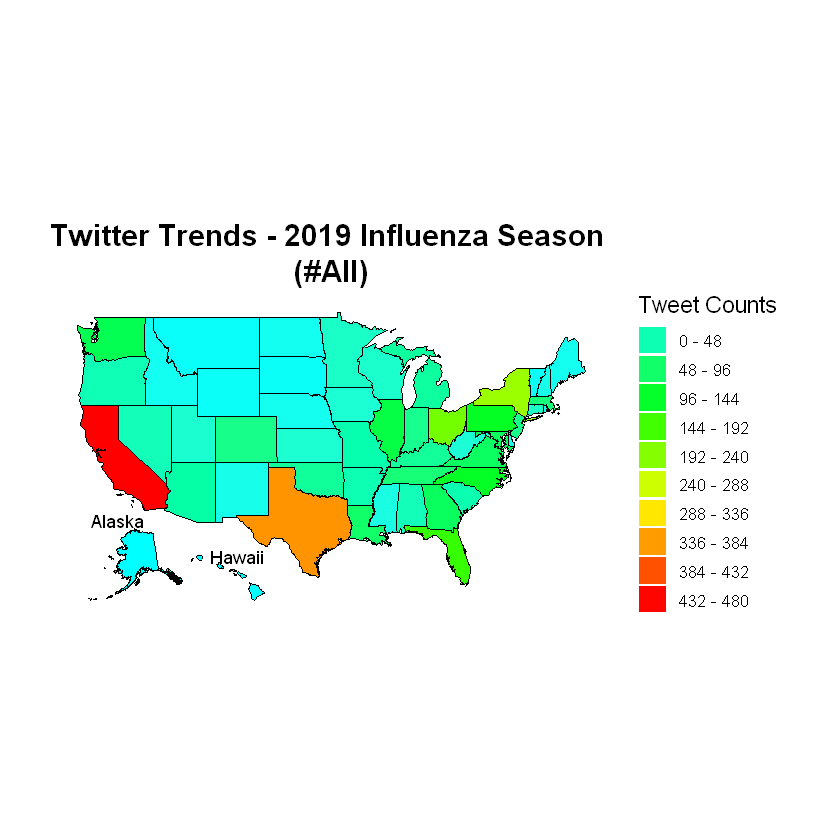

In [6]:
rt_state_DF <- read.csv("filtered_state_data_tweets.csv", header=TRUE)

df_states <- table(fifty_states$id)
df_states <- as.data.frame(df_states)
x_header <- c("region","count")
colnames(df_states) <- x_header

# get the count for each state
state_counts <- table(rt_state_DF$region)
state_counts <- as.data.frame(state_counts)
x_header <- c("region","count")
colnames(state_counts) <- x_header

flu_map <- merge(df_states, state_counts, by="region", all = T)
flu_map[is.na(flu_map)] <- 0

# plotting map
fifty_states$region <- fifty_states$id

flu_map <- merge(fifty_states, flu_map, by="region", all.flu_map = T)
flu_map <- flu_map[order(flu_map$order),]

max_cnt <- max(flu_map$count.y)
cnt_factor <- as.integer(max_cnt/10)

labels_map <- c()

for (variable in 1:10) {
  labels_map[variable] <- paste((variable - 1)*cnt_factor,cnt_factor*variable,sep=" - ")
}

plot_theme <- theme(panel.background = element_blank(),
                    plot.margin = unit(c(1,1,1,1), "cm"),
                    plot.title=element_text(size=18, 
                                            face="bold", 
                                            color="black",
                                            hjust=0.5,
                                            lineheight=1.0),  # title
                    plot.subtitle=element_text(size=16, 
                                               color = "black",
                                               face="bold",
                                               hjust=0.5),  # subtitle
                    plot.caption=element_text(size=15),  # caption
                    axis.title.x=element_blank(),
                    axis.title.y = element_blank(),
                    axis.text.x = element_blank(),  # X axis text
                    axis.text.y=element_blank(),
                    axis.line = element_blank(),
                    legend.title = element_text(size=14),
                    legend.key = element_blank(),
                    axis.ticks.x = element_blank(),
                    axis.ticks.y = element_blank(),
                    legend.text = element_text(size=10))  # Y axis text

fluHeatmap <- ggplot(flu_map, aes(x=long, y=lat, group=group)) + 
  geom_polygon(aes(fill=flu_map$count.y), data=fifty_states) +
  geom_path() +
  annotate("text", x=-120, y=31.5, label="Alaska") +
  annotate("text", x = -106.5, y = 28, label = "Hawaii") +
  labs(title = "Twitter Trends - 2019 Influenza Season 
(#All)", y = "", x = "") +
  plot_theme + guides(fill=guide_legend(title = "Tweet Counts")) +
  scale_fill_gradientn(colors=rev(rainbow(n = 10, start=0, end=0.5)), breaks = seq(cnt_factor, max_cnt, by=cnt_factor), na.value="grey90", 
                       labels = labels_map) +
  coord_map()

fluHeatmap


![alt text](images/CDCHeatMap.png "CDCHeatMap")

## Analysis - CDC Heatmap vs Twitter Heatmap (All keywords)

All represents all possible relevant keywords associated with flu, influenza, etc. viz. 

##### #flu, #Influenza, #influenzas, #grippe, #Epidemic, #Epidemics, #Pandemics, #contagious, #outbreaks, #Antiviral, #Antivirals, #arbidol, #orthomyxovirus 

to name a few. 

The twitter data was collected over a period of 3 weeks in 2019, starting from February 1st week to March 1st week. 

While collecting the Tweets from the various states based on all possible keywords for 2019, it appeared that California had the most activity and resulted in 480 tweets appearing from geolocations based in California.

Texas was second in place after California with 380 tweets. 

The state of New York had 256 geolocations having twitter activity with those hashtags and keywords. 

Comparing the all keywords - Twitter activity heatmap of USA with that of CDC's website of Week 4 of 2019, ending January 26, it is pretty evident that the maximum concurrence occured between the New York State on both heatmaps. In both heatmaps, NY lies in the moderate region of activity. 

Texas too comes very close to the CDC's heatmap, however there was no activity in California in Week 4 of 2019, contrary to the Twitter heatmap. 

#### Task 5

###### Keywords: Influenza, Vaccine

In [ ]:
keywords <- "flu OR Vaccine"

##### search for tweets sent from the US

In [ ]:
rt <- search_tweets(keywords, include_rts = FALSE, retryonratelimit = TRUE, geocode = lookup_coords("usa"), n = 100000)

##### create lat/lng variables using all available tweet and profile geo-location data

In [ ]:
rt <- lat_lng(rt)

##### saving all the tweets data into a csv file

In [ ]:
save_as_csv(rt, paste("full_data_tweets_task5.csv"), prepend_ids = TRUE, na = "",fileEncoding = "UTF-8")

##### filtering data - neglect tweets that do not have lat long information

In [ ]:
rt_DF <- rt[!is.na(rt$lat),]

##### this will get the state from the lat, lng info and create the list of records
##### get the states from the lat and long coordinates using the revgeo library

In [ ]:
rt_DF$region <- ""

i <- 1
while(i <= nrow(rt_DF)) {
  temp <- revgeo(longitude=rt_DF[i,]$lng, latitude=rt_DF[i,]$lat, output = 'frame', item = 'state') 
  rt_DF[i,]$region <- as.character(tolower(temp$state))
  i <- i + 1
}

##### saving all the filtered tweets data into a csv file

In [ ]:
save_as_csv(rt_DF, paste("state_data_tweets_task5.csv"), prepend_ids = TRUE, na = "",
            fileEncoding = "UTF-8")

##### filtering data - neglect tweets that do not belong to US states

In [ ]:
rt_state_DF <- dplyr::filter(rt_DF, grepl(lst_valid_states, region))

##### saving all the filtered tweets data into a csv file

In [ ]:
save_as_csv(rt_state_DF, paste("filtered_state_data_tweets_task5.csv"), prepend_ids = TRUE, na = "",
            fileEncoding = "UTF-8")

##### Plot heat map for the filtered data - run this to check the final output

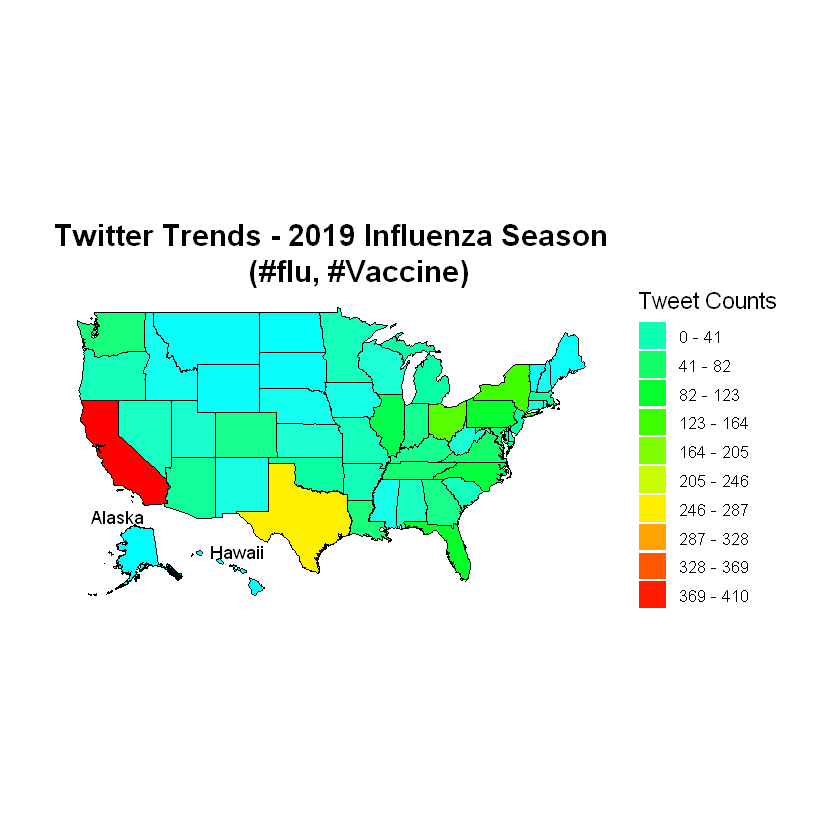

In [20]:
rt_state_DF <- read.csv("filtered_state_data_tweets_task5.csv", header=TRUE)

df_states <- table(fifty_states$id)
df_states <- as.data.frame(df_states)
x_header <- c("region","count")
colnames(df_states) <- x_header

# get the count for each state
state_counts1 <- table(rt_state_DF$region)
state_counts1 <- as.data.frame(state_counts1)
x_header <- c("region","count")
colnames(state_counts1) <- x_header

flu_map1 <- merge(df_states, state_counts1, by="region", all = T)
flu_map1[is.na(flu_map1)] <- 0

# plotting map
fifty_states$region <- fifty_states$id

flu_map1 <- merge(fifty_states, flu_map1, by="region", all.flu_map1 = T)
flu_map1 <- flu_map1[order(flu_map1$order),]

max_cnt1 <- max(flu_map1$count.y)
cnt_factor1 <- as.integer(max_cnt1/10)

labels_map1 <- c()

for (variable in 0:10) {
  labels_map1[variable] <- paste((variable - 1)*cnt_factor1,cnt_factor1*variable,sep=" - ")
}

plot_theme <- theme(panel.background = element_blank(),
                    plot.margin = unit(c(1,1,1,1), "cm"),
                    plot.title=element_text(size=18, 
                                            face="bold", 
                                            color="black",
                                            hjust=0.5,
                                            lineheight=1.0),  # title
                    plot.subtitle=element_text(size=16, 
                                               color = "black",
                                               face="bold",
                                               hjust=0.5),  # subtitle
                    plot.caption=element_text(size=15),  # caption
                    axis.title.x=element_blank(),
                    axis.title.y = element_blank(),
                    axis.text.x = element_blank(),  # X axis text
                    axis.text.y=element_blank(),
                    axis.line = element_blank(),
                    legend.title = element_text(size=14),
                    legend.key = element_blank(),
                    axis.ticks.x = element_blank(),
                    axis.ticks.y = element_blank(),
                    legend.text = element_text(size=10))  # Y axis text

fluHeatmap1 <- ggplot(flu_map1, aes(x=long, y=lat, group=group)) + 
  geom_polygon(aes(fill=flu_map1$count.y), data=fifty_states) +
  geom_path() +
  annotate("text", x=-120, y=31.5, label="Alaska") +
  annotate("text", x = -106.5, y = 28, label = "Hawaii") +
  labs(title = "Twitter Trends - 2019 Influenza Season
       (#flu, #Vaccine)", y = "", x = "") +
  plot_theme + guides(fill=guide_legend(title = "Tweet Counts")) +
  scale_fill_gradientn(colors=rev(rainbow(n = 10, start=0, end=0.5)), breaks = seq(cnt_factor1, max_cnt1, by=cnt_factor1), na.value="grey90", 
                       labels = labels_map1) +
  coord_map()

fluHeatmap1




![alt text](images/CDCHeatMap.png "CDCHeatMap")

## Analysis - CDC Heatmap vs Twitter Heatmap (Only 2 Keywords - flu & vaccine)

Again, when the tweets were filtered out for only two keywords, viz. - 

##### #flu and #vaccine

the maximum count of tweets reached 407, which happened again in the state of California. However, this is again in contrast to the heatmap from the CDC's website. Apparently, California has a extremely high number of active social media users on the topic of Flu [no pun intended]. 

Texas had the next highest activity with these keywords, resulting in 286 tweets appearing from geolocations in that state. Other states like Alaska, Kentucky, West Virginia, New Mexico, Colorado, Utah, Louisiana, Oklahoma, and other neighboring states of Texas which rather had a HIGH activity level of Influenza in the CDC heat map, didn't show much presence through Tweets pertaining to Influenza. 

State of New York fell in the LOW bracket of activity with these keywords on Twitter which was in the MODERATE bracket on CDC's site. 
